In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
%matplotlib inline

In [34]:
a= np.array([[1,],[2,],[3,]])
b=np.arange(1,16).reshape((3,5))
print(a.shape)
print(b.shape)
print(a)
print(b)

print((a*b))
print(type(np.array((a*b).mean())))
print(np.array((a*b).mean(axis=0)))

(3, 1)
(3, 5)
[[1]
 [2]
 [3]]
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]]
[[ 1  2  3  4  5]
 [12 14 16 18 20]
 [33 36 39 42 45]]
<class 'numpy.ndarray'>
[15.33333333 17.33333333 19.33333333 21.33333333 23.33333333]


In [3]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')       

In [48]:
# A class that implements log linear regression using logistic sigmoid func as activation func
@dataclass
class LogisticRegressionGD:
    eta:float=0.05
    n_iter:int=50
    seed:float=2.0

    # flowchart
    # fit -> net_input: w.T @ X + b -> activation: calculate sigma(z) -> predict: assign label according to sigma(z) 
    def fit(self, X, y):
        # initialize parameters
        self.errors = []
        self.losses = []
        y=y.reshape((-1,1))

        # X: n x m   y: n x 1
        # initialize w, b
        self.w=np.random.RandomState(seed=self.seed).normal(loc=0,scale=0.05,size=(X.shape[1],1))  # m x 1
        self.b=np.float_(0.)

        for _ in range(self.n_iter):
            # 150 x 3 * 3 x 1   = 150 x 1
            sig_z=self.activation(self.net_input(X))  # n x 1
            y_hat=self.predict(X)  # n x 1
            
            # record error
            error= y-y_hat
            self.errors.append(error.sum())

            # calc loss func
            loss=(-y*np.log(sig_z) - (1-y)*np.log(1-sig_z)).mean()
            self.losses.append(loss)
            
            # calc delta_w and delta_b
            delta_b = 2*(self.eta * error).mean()
            # n x 1 elementwise* n x m = n x m same as multiply the column vector to each column of the matrix then calc column average
            delta_w = np.array(2*((self.eta * error) * X).mean(axis=0)).reshape((1,-1))  

            # update w and b
            self.b+=delta_b
            # print(self.w.shape,delta_w.shape)
            self.w+=delta_w.T
        return self

    def net_input(self, X):
        # this is to calculate z = wX + b
        # n x m * m x 1 + n x 1 = n x 1
        z = X @ self.w +self.b
        return z

    def activation(self, z):
        sig_z = 1 / (1+np.exp(-z))
        return sig_z

    def predict(self, X):
        y_hat = np.where(self.activation(self.net_input(X))>=0.5, 1, 0)
        return y_hat


In [5]:
# generate train and test data
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)


print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

# Standardizing the features:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


X_train shape: (70, 2), y_train shape: (70,)


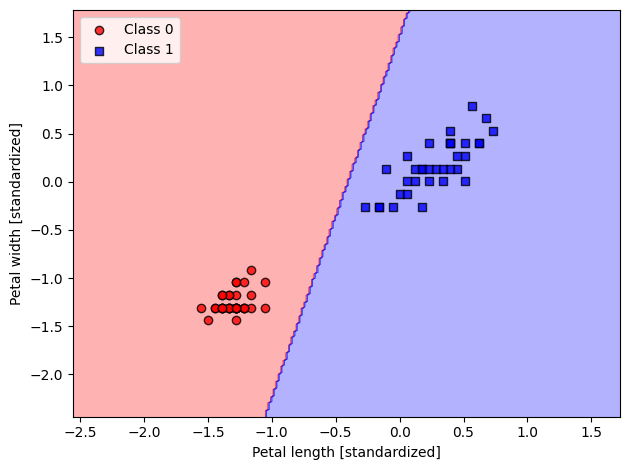

In [60]:
# train iris dataset on LRGD
X_train_01_subset=X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset=y_train[(y_train == 0) | (y_train == 1)]

lrgd=LogisticRegressionGD(eta=0.3,n_iter=1000, seed=1)

print(f"X_train shape: {X_train_01_subset.shape}, y_train shape: {y_train_01_subset.shape}")
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

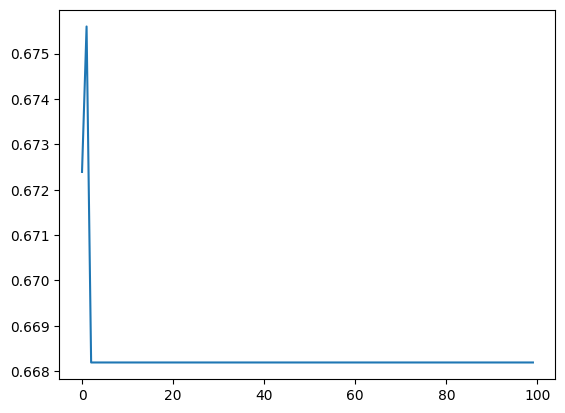

In [62]:
plt.plot(lrgd.losses[:100])

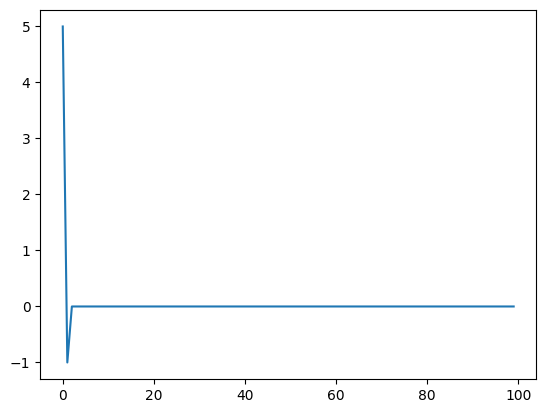

In [64]:
plt.plot(lrgd.errors[:100])